The objective of this tutorial is to demonstrate how to obtain word embeddings from a pre-trained model, Google's BERT. It is based on Chris McCormick's tutorial. You can find the original post [here](http://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/).




# 1. Loading Pre-Trained BERT

Install the pytorch interface for BERT by Hugging Face. 

If you're running this code on Google Colab, you will have to install this library each time you reconnect; the following cell will take care of that for you.

In [ ]:
!pip install transformers

     |████████████████████████████████| 778kB 3.4MB/s 
     |████████████████████████████████| 3.0MB 16.3MB/s 
     |████████████████████████████████| 1.1MB 21.2MB/s 
     |████████████████████████████████| 890kB 44.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=f18896e159a63803e59d0795e432ce65465b1fee276f2741142f160192f1c376
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


Now let's import pytorch, the pretrained BERT model, and a BERT tokenizer. 

There are several variations of BERT models released, but the one we'll use here is the smaller of the two available sizes ("base" and "large") and ignores casing, hence "uncased.""

`transformers` provides a number of classes for applying BERT to different tasks (token classification, text classification, ...). Here, we're using the basic `BertModel` which has no specific output task--it's a good choice for using BERT just to extract embeddings.

In [ ]:
import torch
from transformers import BertTokenizer, BertModel

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


# 2. Input Formatting
Because BERT is a pretrained model that expects input data in a specific format, we will need:

1. A **special token, `[SEP]`,** to mark the end of a sentence, or the separation between two sentences
2. A **special token, `[CLS]`,** at the beginning of our text. This token is used for classification tasks, but BERT expects it no matter what your application is. 
3. Tokens that conform with the fixed vocabulary used in BERT
4. The **Token IDs** for the tokens, from BERT's tokenizer
5. **Mask IDs** to indicate which elements in the sequence are tokens and which are padding elements
6. **Segment IDs** used to distinguish different sentences
7. **Positional Embeddings** used to show token position within the sequence

Luckily, the `transformers` interface takes care of all of the above requirements (using the `tokenizer.encode_plus` function). 

Since this is intended as an introduction to working with BERT, though, we're going to perform these steps in a (mostly) manual way. 


## 2.1. Tokenization

BERT provides its own tokenizer, which we imported above. Let's see how it handles the below sentence.

In [ ]:
sent1 = "My dog is cute."
sent2 = "He likes playing."
marked_pair = "[CLS] " + sent1 + " [SEP]" + sent2 + " [SEP]"

# Tokenize our sentence with the BERT tokenizer.
tokenized_pair = tokenizer.tokenize(marked_pair)

# Print out the tokens.
print (tokenized_pair)

['[CLS]', 'my', 'dog', 'is', 'cute', '.', '[SEP]', 'he', 'likes', 'playing', '.', '[SEP]']


BERT tokenizer was created with a WordPiece model. This model greedily creates a fixed-size vocabulary of individual characters, subwords, and words that best fits our language data. Since the vocabulary limit size of our BERT tokenizer model is 30,000, the WordPiece model generated a vocabulary that contains all English characters plus the ~30,000 most common words and subwords found in the English language corpus the model is trained on. 

Then, for words that are not in the vocabulary, rather than assigning out of vocabulary words to a catch-all token like 'OOV' or 'UNK,'  they are decomposed into subword and character tokens that we can then generate embeddings for. 

(For more information about WordPiece, see the [original paper](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/37842.pdf) .)

In [ ]:
print("playing" in tokenizer.wordpiece_tokenizer.vocab)
print("slacking" in tokenizer.wordpiece_tokenizer.vocab)

True
False


In [ ]:
#let's change the word 'playing' to 'slacking' (not in vocab) in sent2
sent2 = "He likes slacking."
marked_pair = "[CLS] " + sent1 + " [SEP]" + sent2 + " [SEP]"

# Tokenize our sentence with the BERT tokenizer.
tokenized_pair = tokenizer.tokenize(marked_pair)

# Print out the tokens.
print (tokenized_pair)

['[CLS]', 'my', 'dog', 'is', 'cute', '.', '[SEP]', 'he', 'likes', 'slack', '##ing', '.', '[SEP]']


Notice how the word "slackings" is represented:

`['slack', '##ing']`

The original word has been split into smaller subwords and characters. The two hash signs preceding some of these subwords are just our tokenizer's way to denote that this subword or character is part of a larger word and preceded by another subword. 





Here are some examples of the tokens contained in our vocabulary. Tokens beginning with two hashes are subwords or individual characters.

In [ ]:
print(tokenizer.vocab_size)
print(list(tokenizer.vocab.keys())[3010:3020])

30522
['canadian', 'earth', '##ity', 'cut', 'degree', 'writing', 'bay', 'christian', 'awarded', 'natural']


After breaking the text into tokens, we then have to convert the sentence from a list of strings to a list of vocabulary indices.

To illustrate BERT's capability of producing contextualized word embeddings, from here on, we'll use the below example sentence, which contains two instances of the word "bank" with different meanings.

In [ ]:
# Define a new example sentence with multiple meanings of the word "bank"
text = "After stealing money from the bank vault, the bank robber was seen " \
       "fishing on the Mississippi river bank."

# Add the special tokens.
marked_text = "[CLS] " + text + " [SEP]"

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
after         2,044
stealing     11,065
money         2,769
from          2,013
the           1,996
bank          2,924
vault        11,632
,             1,010
the           1,996
bank          2,924
robber       27,307
was           2,001
seen          2,464
fishing       5,645
on            2,006
the           1,996
mississippi   5,900
river         2,314
bank          2,924
.             1,012
[SEP]           102


## 2.2. Segment ID
BERT is trained on and expects sentence pairs, using 1s and 0s to distinguish between the two sentences. That is, for each token in "tokenized_text," we must specify which sentence it belongs to: sentence 0 (a series of 0s) or sentence 1 (a series of 1s). For our purposes, single-sentence inputs only require a series of 1s, so we will create a vector of 1s for each token in our input sentence. 

If you want to process two sentences, assign each word in the first sentence plus the '[SEP]' token a 0, and all tokens of the second sentence a 1.

In [ ]:
# Mark each of the 22 tokens as belonging to sentence "1".
segments_ids = [1] * len(tokenized_text)

print (segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


# 3. Extracting Embeddings 



## 3.1. Running BERT on our text



Next we need to convert our data to torch tensors and call the BERT model. The BERT PyTorch interface requires that the data be in torch tensors rather than Python lists, so we convert the lists here - this does not change the shape or the data.
 

In [ ]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensor = torch.tensor([segments_ids])
print(tokens_tensor.size())
print(segments_tensor.size())

torch.Size([1, 22])
torch.Size([1, 22])


Calling `from_pretrained` will fetch the model from the internet. When we load the `bert-base-uncased`, we see the definition of the model printed in the logging. The model is a deep neural network with 12 layers! Explaining the layers and their functions is outside the scope of this post, and you can skip over this output for now.

model.eval() puts our model in evaluation mode as opposed to training mode. In this case, evaluation mode turns off dropout regularization which is used in training.

In [ ]:
# Load pre-trained model (weights). The model returns all hidden-states.
                                 
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

Next, let's evaluate BERT on our example text, and fetch the hidden states of the network!

*Side note: `torch.no_grad` tells PyTorch not to construct the compute graph during this forward pass (since we won't be running backprop here)--this just reduces memory consumption and speeds things up a little.*


In [ ]:
# Run the text through BERT, and collect all of the hidden states produced
# from all 12 layers. 
with torch.no_grad():

    outputs = model(tokens_tensor, segments_tensor)

    # Evaluating the model will return a different number of objects based on 
    # how it's  configured in the `from_pretrained` call earlier. In this case, 
    # becase we set `output_hidden_states = True`, the third item will be the 
    # hidden states from all layers. See the documentation for more details:
    # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    hidden_states = outputs[2]

## 3.2. Understanding the Output



The full set of hidden states for this model, stored in the object `hidden_states`, has four dimensions, in the following order:

1. The layer number (13 layers)
2. The batch number (1 sentence)
3. The word / token number (22 tokens in our sentence)
4. The hidden unit / feature number (768 features)

Wait, 13 layers? Because the first element is the input embeddings, the rest is the outputs of each of BERT's 12 layers. 

That’s 219,648 unique values just to represent our one sentence! 

The second dimension, the batch size, is used when submitting multiple sentences to the model at once; here, though, we just have one example sentence.

In [ ]:
print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0

print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 22
Number of hidden units: 768


Let's take a quick look at the range of values for a given layer and token.

You'll find that the range is fairly similar for all layers and tokens, with the majority of values falling between \[-2, 2\], and a small smattering of values around -10.

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

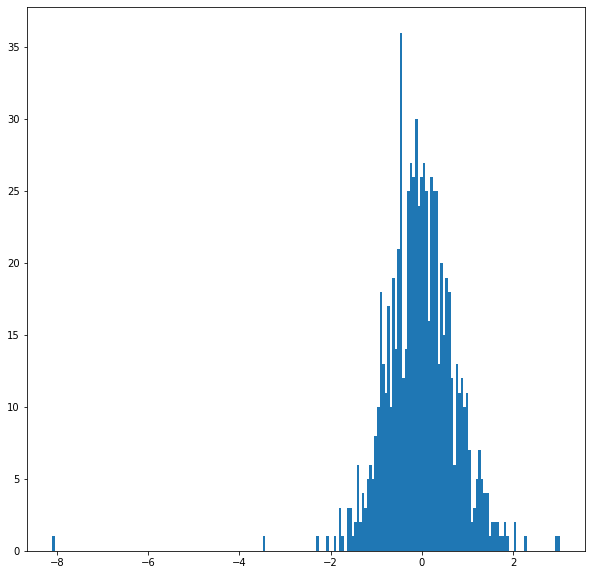

In [ ]:
# For the 3rd token 'money' in our sentence, select its feature values from layer 5.
token_i = 3
layer_i = 5
vec = hidden_states[layer_i][batch_i][token_i]

# Plot the values as a histogram to show their distribution.

plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

Grouping the values by layer makes sense for the model, but for our purposes we want it grouped by token. 

Current dimensions:

`[# layers, # batches, # tokens, # features]`

Desired dimensions:

`[# tokens, # layers, # features]`

Luckily, PyTorch includes the `permute` function for easily rearranging the dimensions of a tensor. 

However, the first dimension is currently a Python list! 

In [ ]:
# `hidden_states` is a Python list.
print('      Type of hidden_states: ', type(hidden_states))

# Each layer in the list is a torch tensor.
print('Tensor shape for each layer: ', hidden_states[0].size())


      Type of hidden_states:  <class 'tuple'>
Tensor shape for each layer:  torch.Size([1, 22, 768])


Let's combine the layers to make this one whole big tensor.

In [ ]:
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
token_embeddings = torch.stack(hidden_states, dim=0)

token_embeddings.size()

torch.Size([13, 1, 22, 768])

Let's get rid of the "batches" dimension since we don't need it.

In [ ]:
# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

torch.Size([13, 22, 768])

Finally, we can switch around the "layers" and "tokens" dimensions with `permute`.

In [ ]:
# Swap dimensions 0 and 1.
token_embeddings = token_embeddings.permute(1,0,2)

token_embeddings.size()

torch.Size([22, 13, 768])

## 3.3. Creating word and sentence vectors from hidden states

Now, for each token of our input we have 13 separate vectors each of length 768. Which layer or combination of layers provides the best representation of each token? And how to get a single vector representation of the whole sentence? 

Unfortunately, there's no single easy answer... Let's try a couple reasonable approaches suggested by the original BERT paper.



### Word Vectors

To give you some examples, let's create word vectors two ways. 

First, let's **concatenate** the last four layers, giving us a single word vector per token. Each vector will have length `4 x 768 = 3,072`. 

In [ ]:
token_embeddings.size()

torch.Size([22, 13, 768])

In [ ]:
# Stores the token vectors, with shape [22 x 3,072]
token_vecs_cat4 = []

# `token_embeddings` is a [22 x 13 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:
    
    # `token` is a [13 x 768] tensor: 1 embedding + 12 encoders

    # Concatenate the vectors (that is, append them together) from the last 
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
    
    # Use `cat_vec` to represent `token`.
    token_vecs_cat4.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat4), len(token_vecs_cat4[0])))

Shape is: 22 x 3072


As an alternative method, let's try creating the word vectors by **summing** together the last four layers.

In [ ]:
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum4 = []

# `token_embeddings` is a [22 x 13 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [13 x 768] tensor: 1 embedding + 12 encoders

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum4.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum4), len(token_vecs_sum4[0])))

Shape is: 22 x 768


### Sentence Vectors



To get a single vector for our entire sentence we have multiple application-dependent strategies, but a simple approach is to average the second to last hidden layer of each token producing a single 768 length vector.

In [ ]:
# `hidden_states` has shape [13 x 1 x 22 x 768]

# `token_vecs` is a tensor with shape [22 x 768]
token_vecs = hidden_states[-2][0]

# Calculate the average of all 22 token vectors.
sentence_embedding = torch.mean(token_vecs, dim=0)

In [ ]:
print("Shape before taking average: ", token_vecs.size())
print ("Our final sentence embedding vector of shape:", sentence_embedding.size())

Shape before taking average:  torch.Size([22, 768])
Our final sentence embedding vector of shape: torch.Size([768])


## 3.4. Confirming contextually dependent vectors

To confirm that the value of these vectors are in fact contextually dependent, let's look at the different instances of the word "bank" in our example sentence:

"After stealing money from the **bank vault**, the **bank robber** was seen fishing on the Mississippi **river bank**."

Let's find the index of those three instances of the word "bank" in the example sentence.

In [ ]:
for i, token_str in enumerate(tokenized_text):
  print (i, token_str)

0 [CLS]
1 after
2 stealing
3 money
4 from
5 the
6 bank
7 vault
8 ,
9 the
10 bank
11 robber
12 was
13 seen
14 fishing
15 on
16 the
17 mississippi
18 river
19 bank
20 .
21 [SEP]


They are at 6, 10, and 19.

For this analysis, we'll use the word vectors that we created by summing the last four layers.

We can try printing out their vectors to compare them.

In [ ]:
bank1 = token_vecs_sum4[6]
bank2 = token_vecs_sum4[10]
bank3 = token_vecs_sum4[19]

In [ ]:
print('First 5 vector values for each instance of "bank".')
print('')
print("bank vault   ", str(bank1[:5]))
print("bank robber  ", str(bank2[:5]))
print("river bank   ", str(bank3[:5]))

First 5 vector values for each instance of "bank".

bank vault    tensor([ 3.3596, -2.9805, -1.5421,  0.7065,  2.0031])
bank robber   tensor([ 2.7359, -2.5577, -1.3094,  0.6797,  1.6633])
river bank    tensor([ 1.5266, -0.8895, -0.5152, -0.9298,  2.8334])


We can see that the values differ, but let's calculate the cosine similarity between the vectors to make a more precise comparison.

In [ ]:
from scipy.spatial.distance import cosine

# Calculate the cosine similarity between the word bank 
# in "bank robber" vs "river bank" (different meanings).
diff_bank = 1 - cosine(bank2, bank3)

# Calculate the cosine similarity between the word bank
# in "bank robber" vs "bank vault" (same meaning).
same_bank = 1 - cosine(bank2, bank1)

print('Vector similarity for  *similar*  meanings:  %.2f' % same_bank)
print('Vector similarity for *different* meanings:  %.2f' % diff_bank)

Vector similarity for  *similar*  meanings:  0.94
Vector similarity for *different* meanings:  0.69


This looks pretty good!

## Cite
Chris McCormick and Nick Ryan. (2019, May 14). *BERT Word Embeddings Tutorial*. Retrieved from http://www.mccormickml.com
